Import all the libraries that are necessary 

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from skimage.feature import hog
from sklearn import svm
import cv2
from PIL import Image
from tqdm import tqdm
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import zipfile
%matplotlib inline

In [7]:
import os
import ntpath
from os.path import isfile, isdir
from urllib.request import urlretrieve

# Create an output directory in case it does not exist
if not os.path.exists("output_images"):
    os.makedirs("output_images")


Test on a raw image

In [8]:
car = "vehicles.zip"
noncar = "non-vehicles.zip"

carpath = "car"
noncarpath = "noncar"

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(car):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Car data') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip',
            car,
            pbar.hook)
if not isfile(noncar):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Non-car data') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip',
            noncar,
            pbar.hook)

if not isdir(carpath):
    zipcar = zipfile.ZipFile(car, 'r')
    zipcar.extractall(carpath)
    zipcar.close()
    
if not isdir(noncarpath):
    zipnoncar = zipfile.ZipFile(noncar, 'r')
    zipnoncar.extractall(noncarpath)
    zipnoncar.close()
    


In [55]:
import glob

def ReadImages(car_imgs, carlist):
    for car_img in car_imgs:
        carlist.append(car_img)

cars = []
notcars = []

car_images = glob.glob('car/vehicles/GTI_Far/*.png')
ReadImages(car_images, cars)
car_images = glob.glob('car/vehicles/GTI_Left/*.png')
ReadImages(car_images, cars)
car_images = glob.glob('car/vehicles/GTI_MiddleClose/*.png')
ReadImages(car_images, cars)
car_images = glob.glob('car/vehicles/GTI_Right/*.png')
ReadImages(car_images, cars)


car_images = glob.glob('noncar/non-vehicles/GTI/*.png')
ReadImages(car_images, notcars)


In [56]:
def data_look(car_list, notcar_list):
    data_dict = {}
    data_dict["n_cars"] = len(car_list)
    data_dict["n_notcars"] = len(notcar_list)
    example_img = car_list[0]
    data_dict["image_shape"] = example_img.shape
    data_dict["data_type"] = example_img.dtype
    return data_dict

data_info = data_look(cars, notcars)

print('Training data contains a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

AttributeError: 'str' object has no attribute 'shape'

In [83]:
from skimage.feature import hog

def bin_spatial(img, color_space='RGB', size=None):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(img)
            # Use cv2.resize().ravel() to create the feature vector
    if size != None:
        features = cv2.resize(feature_image, size).ravel()
    else:
        features = feature_image
    # Return the feature vector
    return features

def get_hog_features(img, orient = 9, pix_per_cell = 8, cell_per_block = 2, vis=False):    
    if vis == True:
        features, hog_img = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                   cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                   visualise=True, feature_vector=False)
        return features, hog_img
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                   cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                   visualise=False, feature_vector=True)
        return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features(imgs, color_space='RGB', hog_channel=0):
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        feature_image = bin_spatial(image, color_space=color_space)
        
        spatial_features = bin_spatial(feature_image, color_space='RGB', size=(32, 32))
#        spatial_features = spatial_features.astype(np.float64)
        
        hist_features = color_hist(feature_image)

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel]))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel])
                    
        # Append the new feature vector to the features list
#        features.append(hog_features)
        features.append(np.concatenate((spatial_features, hog_features)))
    # Return list of feature vectors
    return features


def CompareImage(img1, img2, title1, title2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img1)
    ax1.set_title(title1, fontsize=10)
    ax2.imshow(img2)
    ax2.set_title(title2, fontsize=10)

In [84]:
img1 = mpimg.imread("test_images/test1.jpg")
img2 = mpimg.imread("test_images/test2.jpg")
img3 = mpimg.imread("test_images/test3.jpg")
img4 = mpimg.imread("test_images/test4.jpg")
img5 = mpimg.imread("test_images/test5.jpg")
img6 = mpimg.imread("test_images/test6.jpg")

_, img1 = get_hog_features(img1, vis = True)
_, img2 = get_hog_features(img2, vis = True)
CompareImage(img1, img2, 'Image: 1', 'Image: 2 ')

/Users/hiuchan/anaconda/envs/tensorflow/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


ValueError: The parameter `image` must be a 2-dimensional array

In [86]:
# Divide up into cars and notcars
#images = glob.glob('*.jpeg')
#cars = []
#notcars = []
#for image in images:
#    if 'image' in image or 'extra' in image:
#        notcars.append(image)
#    else:
#        cars.append(image)

# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time

import time

sample_size = 2000
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars)
notcar_features = extract_features(notcars)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 30
print('My SVC predicts: ', svc.predict(X_test[0:n_predict:3]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict:3])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

/Users/hiuchan/anaconda/envs/tensorflow/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


7.16 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 4836
1.07 Seconds to train SVC...
Test Accuracy of SVC =  0.9812
My SVC predicts:  [ 0.  1.  0.  1.  0.  1.  1.  1.  0.  0.]
For these 30 labels:  [ 0.  1.  0.  1.  0.  1.  1.  1.  0.  0.]
0.00181 Seconds to predict 30 labels with SVC


In [15]:
from sklearn.svm import SVC

# may need to figure out what kernel to use
# gamma and C
# larger C mean more training points are correct
clf = SVC(kernel="linear")
clf.fit(features_train, labels_train)

pred = clf.predict(features_test)

NameError: name 'features_train' is not defined

In [4]:
# Create a function that allow us to display two images in a row for side by side comparsion
def CompareImage(img1, img2, title1, title2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img1)
    ax1.set_title(title1, fontsize=10)
    ax2.imshow(img2)
    ax2.set_title(title2, fontsize=10)

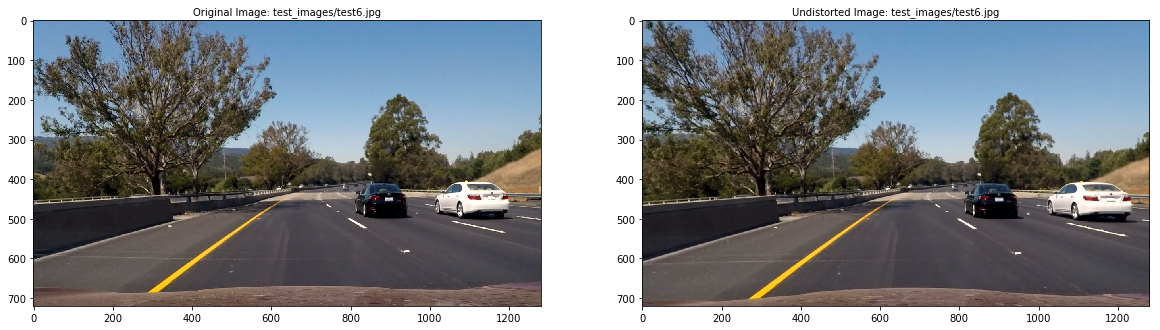

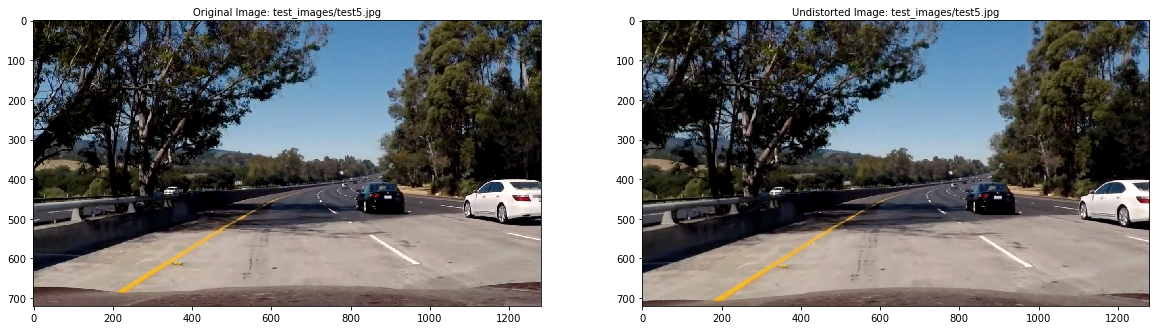

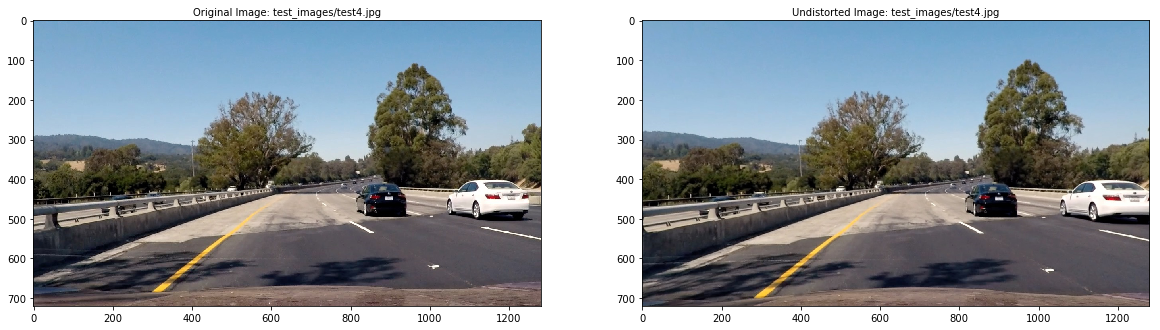

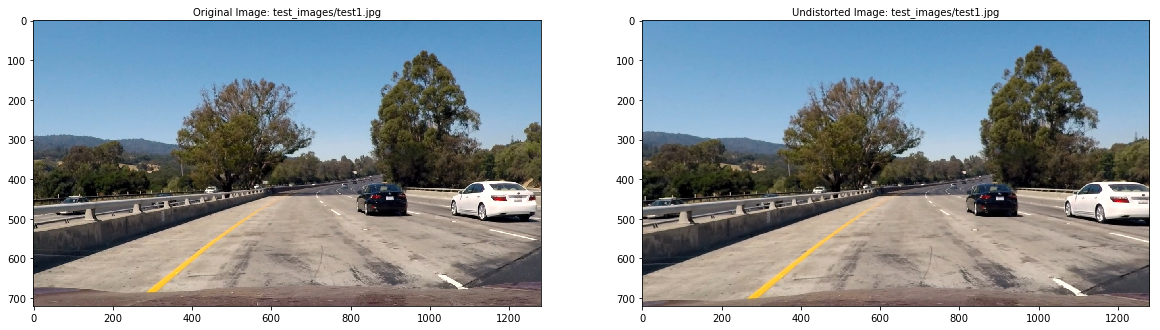

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


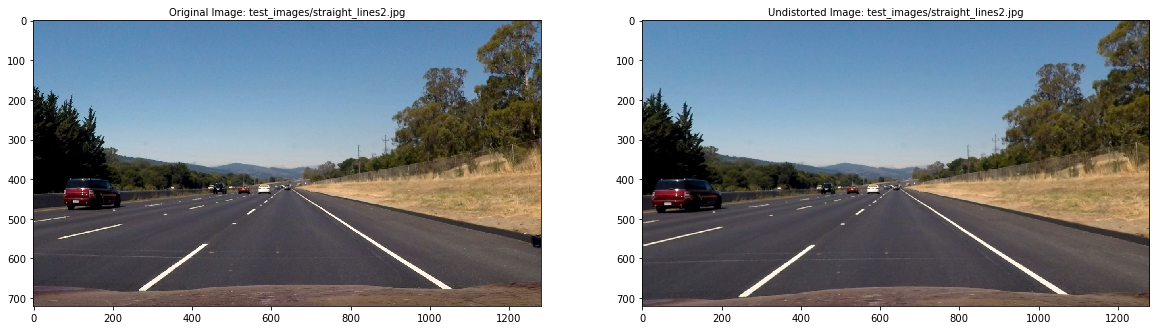

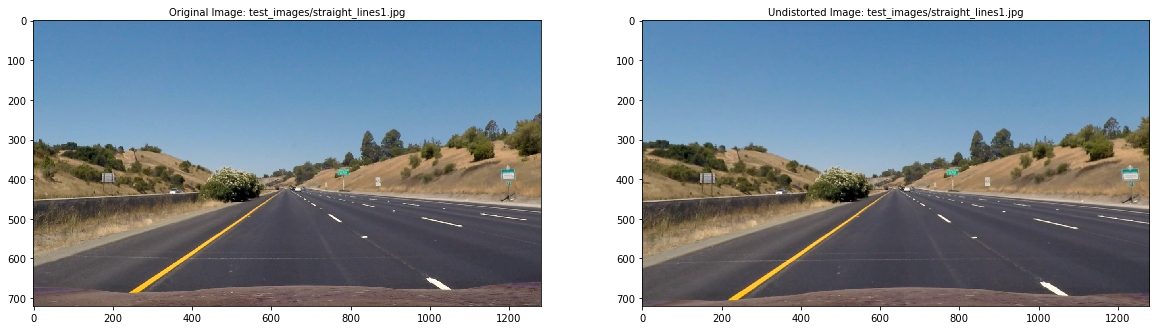

In [7]:
images = glob.glob('test_images/*.jpg')
for fname in images:
    img = mpimg.imread(fname)
    dst = UndistortImage(img)
    filename = ntpath.basename(fname)
    im = Image.fromarray(dst)
    im.save("output_images/undistorted_" + filename)
    CompareImage(img, dst, 'Original Image: '+fname, 'Undistorted Image: '+fname)

Here is the function that obtain the S channel of the HLS color spacing. The default threshold of 120 and 255 were choosen.

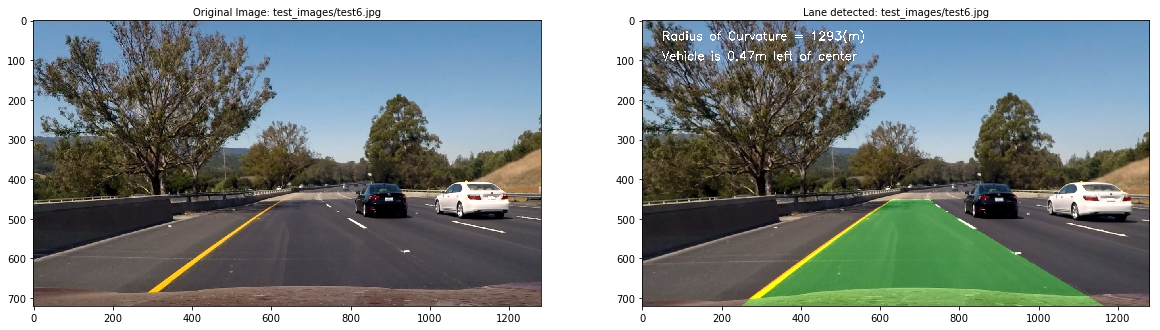

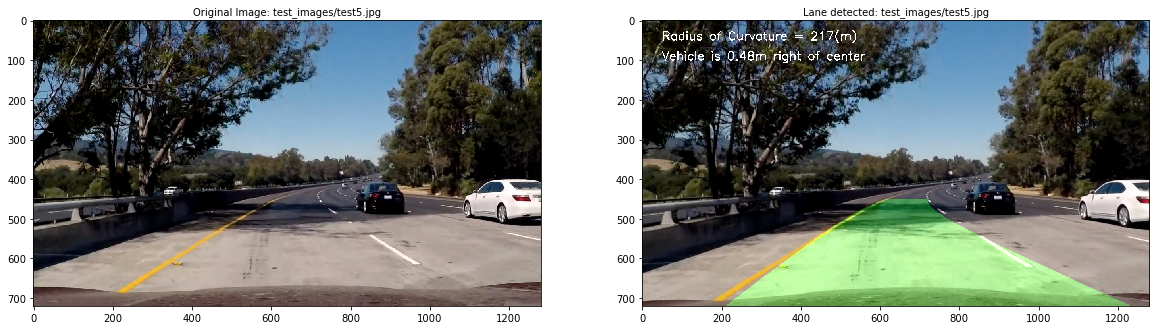

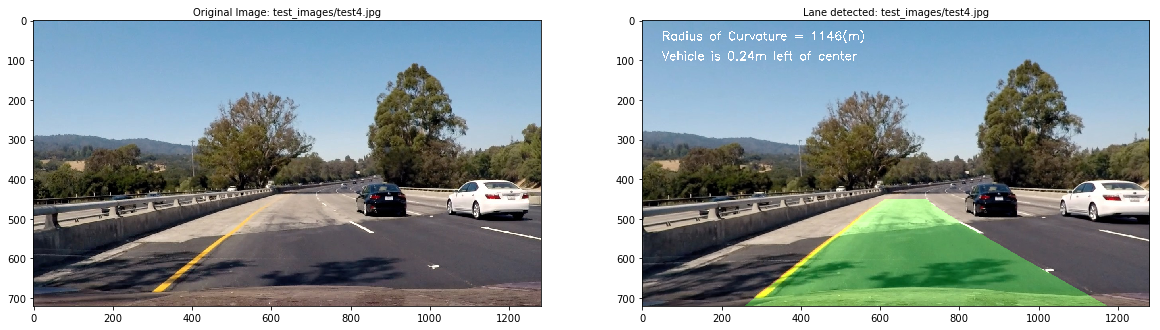

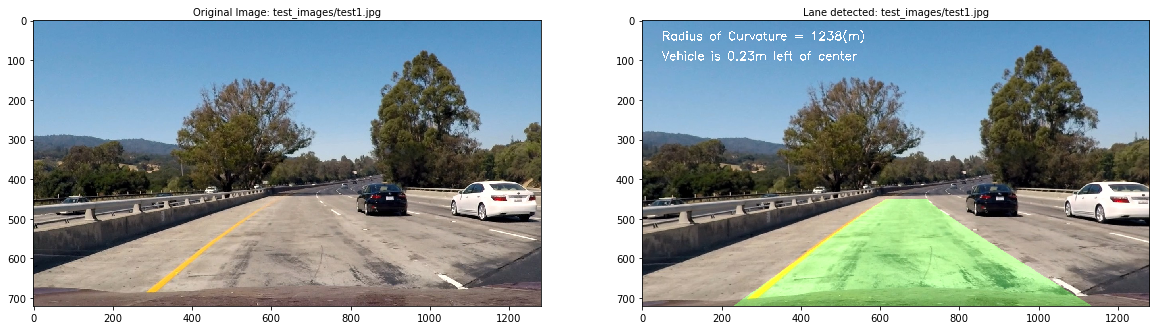

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


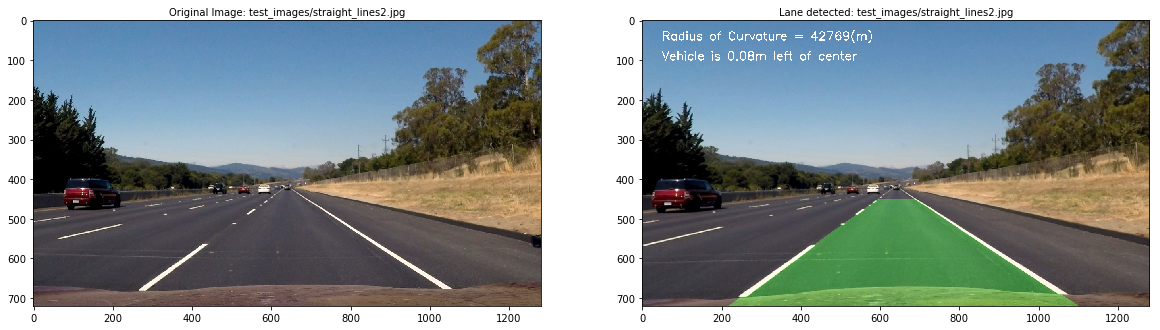

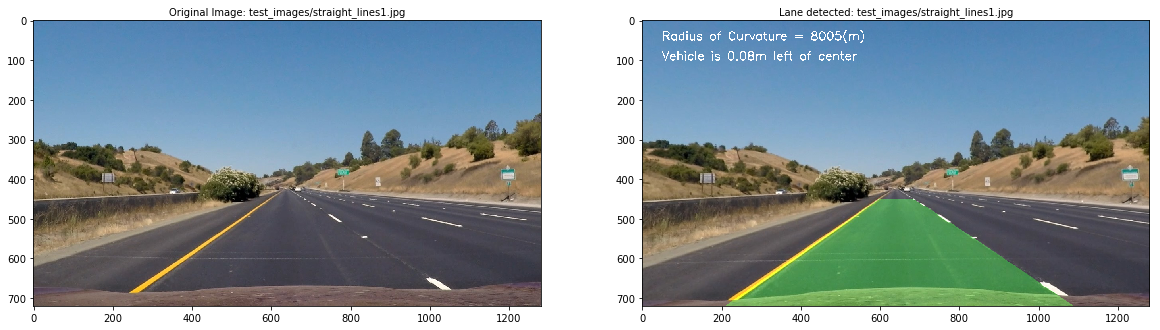

In [22]:
def DetectLaneOnRoad(img):
    img = UndistortImage(img)
    warped, M = WarpBinaryImg(img)
    left_fit, right_fit, out_img = draw_and_fit_lines(warped)
    left, right, center = curvature(left_fit, right_fit, warped)
    return draw_lines(img, warped, left_fit, right_fit, left, right, center, M, show_img = False)


images = glob.glob('test_images/*.jpg')
for fname in images:
    img = mpimg.imread(fname)
    dst = DetectLaneOnRoad(img)
    filename = ntpath.basename(fname)
    im = Image.fromarray(dst)
    im.save("output_images/LaneDetected_" + filename)
    CompareImage(img, dst, 'Original Image: '+fname, 'Lane detected: '+fname)

In [23]:
# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [24]:
def process_image(img):
    return DetectLaneOnRoad(img)


In [25]:
if not os.path.exists("test_videos_output"):
    os.makedirs("test_videos_output")
    
project_output = 'test_videos_output/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [01:53<00:00, 11.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 2min 13s, sys: 14.8 s, total: 2min 28s
Wall time: 1min 53s


In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

Design Consideration and Possible Improvement:

I do not think the camera calibration is hard. It was very straight forward. Determination of which Gradient Threshold to use is not very difficult either since the output of each image from each gradient threshold from jupyter notebook can easily be identified. Warpping the image take some time to fine tune and the way how it is warp also determine the final outcome of the lane detection. To make lane detection more accurate, I have decided to add a region in interest onto the image where I draw a triangle from lower left of the conner of the image, to the center of the image, then back to lower right of the image to help detect the lane line better. The goal is to avoid detecting the side road or the gate on the highway as a lane line.

I found that in california highway, the color of the road can change base of how a particualr region of the road is pave. This can greatly create false positive for the lane detection algorithm. One way to solve it is to look into the  HLV color space of the image, change the brighness accordingly before we try to do gradient threshold and HLS color spacing. The idea is that under a region of the road where the sun light is strong, it may be hard to differentiate the road and the lane line. Reducing the brightness can help identifier the lane line better. In fact, to handle different road scenario, it may make sense to have a pipeline operations of image processing for just one particular scenario of the road condition. For example, under a sunny day with strong sun light but the car is running under a region where there are a lot of trees, We may need to lower the brightness first so that we can see the lane line, then do image noise filtering and then increase the brightness again and do noise filtering again to preserve the lane line and at the same time, remove as much dark spots as we can on the road (I found that some region of the project where there are a lot of dark spots)